# Exploratory Data Analysis – E-commerce Fraud Data

## Objective
This notebook explores the e-commerce transaction dataset to understand fraud patterns,
assess data quality, and identify features useful for fraud detection.
The focus is on class imbalance, user behavior, and transaction timing.


📌 Load & Clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


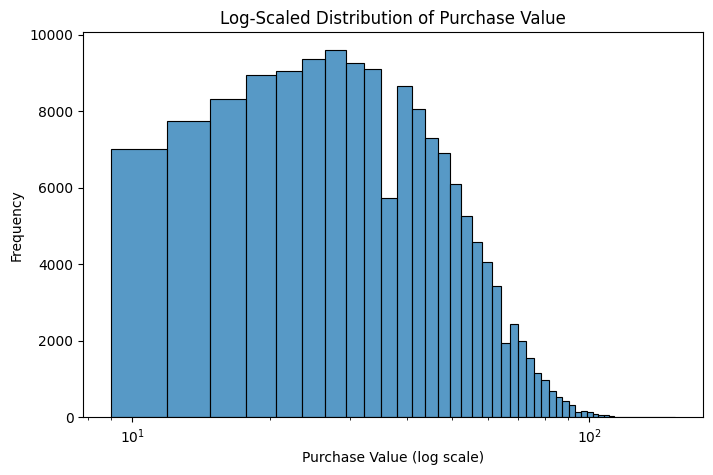

In [7]:
# Exploratory Data Analysis for Fraud Detection
# Allow imports from src/
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
from src.data_loader import load_fraud_data
from src.preprocessing import clean_fraud_data

df = load_fraud_data("../data/raw/Fraud_Data.csv")
df.shape
df = clean_fraud_data(df)
df.head()
df.info()

plt.figure(figsize=(8, 5))
sns.histplot(df["purchase_value"], bins=50)
plt.xscale("log")
plt.title("Log-Scaled Distribution of Purchase Value")
plt.xlabel("Purchase Value (log scale)")
plt.ylabel("Frequency")
plt.show()


The dataset contains transaction-level information including user behavior,
transaction timing, device details, and a binary fraud label.

In [8]:
df.isna().sum().sort_values(ascending=False)
df.describe(include='all').T
df.nunique().sort_values(ascending=False)
df.dtypes
df['class'].value_counts(normalize=True) * 100
# df['FRAUD'].value_counts()


class
0    90.635423
1     9.364577
Name: proportion, dtype: float64

Missing values were observed in demographic and categorical fields.
Numerical features were imputed using the median to reduce sensitivity to outliers,
while categorical features were filled with "Unknown" to preserve row count.


📊 Class Imbalance

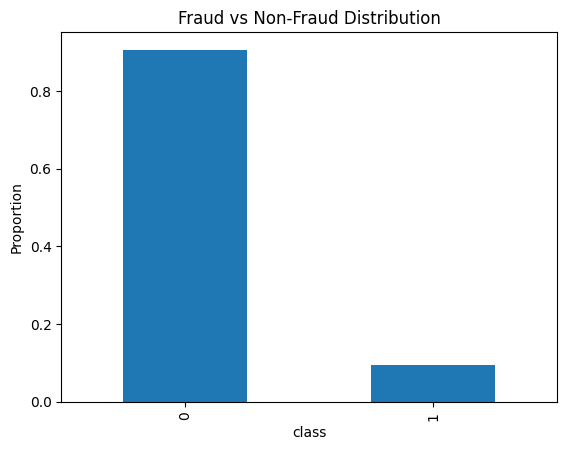

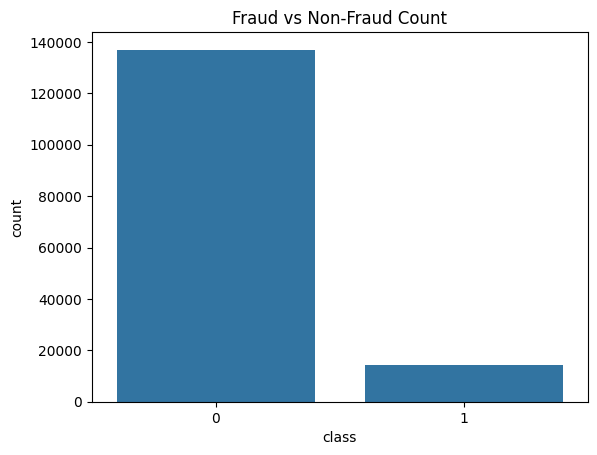

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
df["class"].value_counts(normalize=True) * 100

df["class"].value_counts(normalize=True).plot(kind="bar")
plt.title("Fraud vs Non-Fraud Distribution")
plt.ylabel("Proportion")
plt.show()
sns.countplot(x="class", data=df)
plt.title("Fraud vs Non-Fraud Count")
plt.show()


Only a very small percentage of transactions are fraudulent,
confirming a severe class imbalance. This makes accuracy an unsuitable
metric and motivates the use of resampling and cost-sensitive models later.


📊 Purchase Value vs Fraud

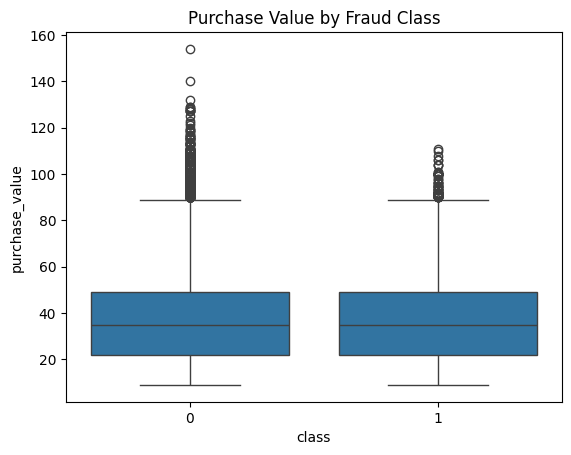

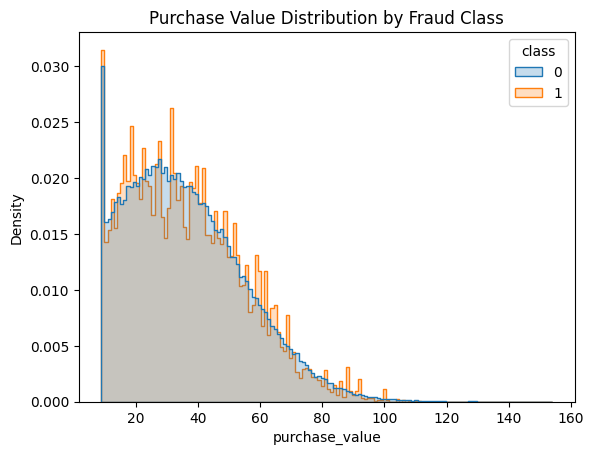

In [10]:
# Purchase Value vs Fraud
sns.boxplot(x="class", y="purchase_value", data=df)
plt.title("Purchase Value by Fraud Class")
plt.show()
sns.histplot(data=df, x="purchase_value", hue="class", element="step", stat="density", common_norm=False)
plt.title("Purchase Value Distribution by Fraud Class")
plt.show()


Fraudulent transactions show a different purchase value distribution,
suggesting transaction amount alone is insufficient but informative when
combined with behavioral features.



📊 Time Since Signup vs Fraud

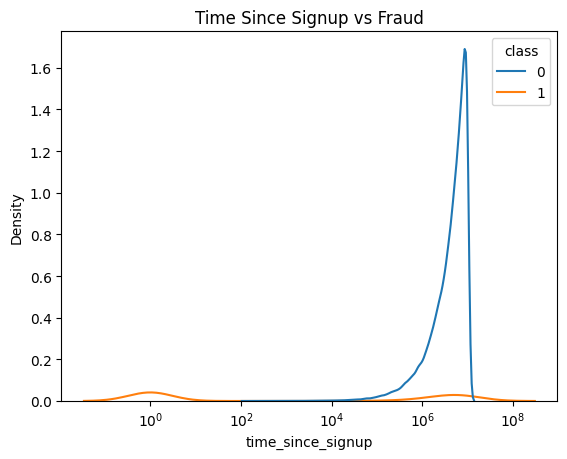

In [11]:
# Time Since Signup vs Fraud
df["time_since_signup"] = (
    df["purchase_time"] - df["signup_time"]
).dt.total_seconds()

sns.kdeplot(
    data=df,
    x="time_since_signup",
    hue="class",
    log_scale=True
)
plt.title("Time Since Signup vs Fraud")
plt.show()

Fraudulent transactions tend to occur shortly after signup,
indicating potential abuse of newly created accounts.
This supports the inclusion of time_since_signup as a key feature.


## IP → Country Fraud Analysis

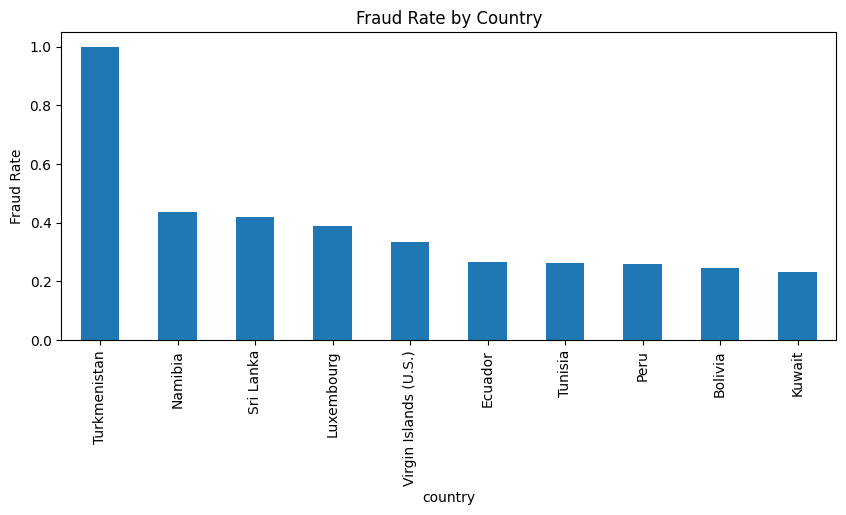

In [12]:

import numpy as np
import pandas as pd
from src.geo_utils import convert_ip_to_int, merge_ip_country

# Base directory: project root
BASE_DIR = Path("..")

# Data paths
fraud_path = BASE_DIR / "data" / "raw" / "Fraud_Data.csv"
ip_path = BASE_DIR / "data" / "raw" / "IpAddress_to_Country.csv"

# Convert IP to integer
df = convert_ip_to_int(df)

# Load IP-to-country mapping
ip_df = pd.read_csv(ip_path)

# Merge country info
df = merge_ip_country(df, ip_df)

assert "country" in df.columns
df[["ip_address", "country"]].head()

fraud_rate_country = df.groupby("country")["class"].mean().sort_values(ascending=False)
fraud_rate_country.head(10).plot(kind="bar", figsize=(10,4))
plt.title("Fraud Rate by Country")
plt.ylabel("Fraud Rate")
plt.show()

Fraud rates vary significantly by country, highlighting the value
of geolocation features in detecting anomalous behavior.
